<a href="https://colab.research.google.com/github/alfredogardel/LibreLane/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LibreLane Colab

This Google Colab notebook will:
* Install LibreLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [2]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/51a27e4a011e95cb559e37d32c44cf89b50f5154/logo/nix-snowflake-colours.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing LibreLane.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown FOSSi Foundation Nix Cache.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://librelane.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
from pathlib import Path
import subprocess
import sys
import shutil
import tempfile

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        with tempfile.TemporaryDirectory() as d:
            d = Path(d)
            installer_path = d / "nix"
            !curl --proto '=https' --tlsv1.2 -sSf -L https://install.determinate.systems/nix > {installer_path}
            with subprocess.Popen(
                [
                    "bash",
                    installer_path,
                    "install",
                    "--prefer-upstream-nix",
                    "--no-confirm",
                    "--extra-conf",
                    "extra-substituters = https://nix-cache.fossi-foundation.org\nextra-trusted-public-keys = nix-cache.fossi-foundation.org:3+K59iFwXqKsL7BNu6Guy0v+uTlwsxYQxjspXzqLYQs=\n",
                ],
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                encoding="utf8",
            ) as p:
                for line in p.stdout:
                    print(line, end="")
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

info: downloading installer
 INFO nix-installer v3.11.2

Important: The Determinate Nix Installer will stop distributing upstream Nix no sooner than January 1, 2026.

Timeline
* November 10: we are changing the installer to default to Determinate Nix.
  You can add the `--prefer-upstream-nix` flag now to keep upstream Nix as the default.
* January 1: we are removing support for installing upstream Nix.
  The `--prefer-upstream-nix` flag will not have an effect any longer.

The DeterminateSystems/nix-installer-action GitHub Action is also affected.

Details: https://determinate.systems/blog/installer-dropping-upstream/
 INFO Step: Create directory `/nix`
 INFO Step: Provision Nix
 INFO Step: Create build users (UID 30001-30032) and group (GID 30000)
 INFO Step: Configure Nix
 INFO Step: Create directory `/etc/tmpfiles.d`
 INFO Step: Configure upstream Nix daemon service
 INFO Step: Remove directory `/nix/temp-install-dir`
 WARN SelfTest([ShellFailed { shell: Sh, command: "\"sh\" \"-lc\"

In [4]:
# @title Get LibreLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install LibreLane.
# @markdown
# @markdown This will install LibreLane's tool dependencies using Nix,
# @markdown and LibreLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

librelane_version = "latest"  # @param {key:"LibreLane Version", type:"string"}

if librelane_version == "latest":
    librelane_version = "main"

pdk_root = "~/.ciel"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

librelane_ipynb_path = os.path.join(os.getcwd(), "librelane_ipynb")

display(IPython.display.HTML("<h3>Downloading LibreLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {librelane_ipynb_path}
!mkdir -p {librelane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {librelane_ipynb_path}
else:
    !curl -L "https://github.com/librelane/librelane/tarball/{librelane_version}" | tar -xzC {librelane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading LibreLane's dependencies…</a>"))
try:
    with subprocess.Popen(
        [
            "nix",
            "profile",
            "install",
            ".#colab-env",
        ],
        cwd=librelane_ipynb_path,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        encoding="utf8",
    ) as p:
        for line in p.stdout:
            print(line, end="")
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=librelane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import ciel
from ciel.source import StaticWebDataSource

ciel.enable(
    ciel.get_ciel_home(pdk_root),
    pdk,
    open(
        os.path.join(librelane_ipynb_path, "librelane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
    data_source=StaticWebDataSource("https://fossi-foundation.github.io/ciel-releases"),
)

sys.path.insert(0, librelane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9525k    0 9525k    0     0  10.9M      0 --:--:-- --:--:-- --:--:-- 10.9M


Version 0fe599b2afb6708d281543108caf8310912f54af enabled for the sky130 PDK.

In [5]:
import librelane

print(librelane.__version__)

2.4.2


### Creating the design

Now that LibreLane is set up, we can write a Verilog file as follows:

In [6]:
%%writefile spm.v
module spm(clk, rst, x, y, p);
    parameter size = 32;
    input clk, rst;
    input y;
    input[size-1:0] x;
    output p;

    wire[size-1:1] pp;
    wire[size-1:0] xy;

    genvar i;

    CSADD csa0 (.clk(clk), .rst(rst), .x(x[0]&y), .y(pp[1]), .sum(p));
    generate for(i=1; i<size-1; i=i+1) begin
        CSADD csa (.clk(clk), .rst(rst), .x(x[i]&y), .y(pp[i+1]), .sum(pp[i]));
    end endgenerate
    TCMP tcmp (.clk(clk), .rst(rst), .a(x[size-1]&y), .s(pp[size-1]));

endmodule

module TCMP(clk, rst, a, s);
    input clk, rst;
    input a;
    output reg s;

    reg z;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            s <= 1'b0;
            z <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            z <= a | z;
            s <= a ^ z;
        end
    end
endmodule

module CSADD(clk, rst, x, y, sum);
    input clk, rst;
    input x, y;
    output reg sum;

    reg sc;

    // Half Adders logic
    wire hsum1, hco1;
    assign hsum1 = y ^ sc;
    assign hco1 = y & sc;

    wire hsum2, hco2;
    assign hsum2 = x ^ hsum1;
    assign hco2 = x & hsum1;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            sum <= 1'b0;
            sc <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            sum <= hsum2;
            sc <= hco1 ^ hco2;
        end
    end
endmodule

Writing spm.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://librelane.readthedocs.io/en/latest/reference/api/config/index.html#librelane.config.Config.interactive).



In [7]:
from librelane.config import Config

Config.interactive(
    "spm",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 10
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: spm
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/librelane_ipynb/librelane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.ciel/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.ciel/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.ciel/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.ciel/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.ciel/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.ciel
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  librelane_version: 2.4.2
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain LibreLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from librelane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from librelane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://librelane.readthedocs.io/en/latest/reference/step_config_vars.html

In [9]:
from librelane.steps import Step

* First, get the step (and display its help)...

In [10]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()



### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

Note that Yosys steps do not currently support gzipped standard cell dotlib
files. They are however supported for macros:

https://github.com/YosysHQ/yosys/issues/4830

```

#### Importing
```python
from librelane.steps.pyosys import Synthesis

# or

from librelane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |


#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP` <sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP` <sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP` <sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP` <sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP` <sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP` <sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP` <sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`  | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`  | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`  | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`  | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`  | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`  | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`  | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`  | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of LibreLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`  | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of LibreLane but is more unstable. | `False` |  |
| `SYNTH_ABC_DFF`  | bool | Passes D-flipflop cells through ABC for optimization (which can for example, eliminate identical flip-flops). | `False` |  |
| `SYNTH_ABC_USE_MFS3`  | bool | Experimental: attempts a SAT-based remapping in all area and delay strategies before 'retime', which may improve PPA results. | `False` |  |
| `SYNTH_ABC_AREA_USE_NF`  | bool | Experimental: uses the &nf delay-based mapper with a very high value instead of the amap area mapper, which may be better in some scenarios at recovering area. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`  | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`  | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`  | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_HIERARCHY_MODE`  | 'flatten'｜<br />'deferred_flatten'｜<br />'keep' | Affects how hierarchy is maintained throughout and after synthesis. 'flatten' flattens it during and after synthesis. 'deferred_flatten' flattens it after synthesis. 'keep' never flattens it. | `flatten` |  |
| `SYNTH_SHARE_RESOURCES`  | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`  | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`  | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_ELABORATE_ONLY`  | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`  | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `SYNTH_MUL_BOOTH`  | bool | Runs the booth pass as part of synthesis: See https://yosyshq.readthedocs.io/projects/yosys/en/latest/cmd/booth.html | `False` |  |
| `SYNTH_TIE_UNDEFINED`  | 'high'｜<br />'low' | Whether to tie undefined values low or high. Explicitly provide null if you wish to simply leave them undriven. | `low` |  |
| `SYNTH_WRITE_NOATTR`  | bool | If true, Verilog-2001 attributes are omitted from output netlists. Some utilities do not support attributes. | `True` |  |
| `VERILOG_FILES`  | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`  | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`  | str? | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`  | List[Path]? | Specifies the Verilog `include` directories. | `None` |  |
| `SYNTH_PARAMETERS`  | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `USE_SYNLIG`  | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`  | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [11]:
from librelane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./spm.v"],
    state_in=State(),
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[08:56:00] VERBOSE  Running 'Yosys.Synthesis' at 'librelane_run/1-yosys-synthesis'…                    ]8;id=649831;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=6709;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:56:00] VERBOSE  Logging subprocess to 'librelane_run/1-yosys-synthesis/yosys-synthesis.log'…       ]8;id=139343;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=153713;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

/----------------------------------------------------------------------------\

|  yosys -- Yosys Open SYnthesis Suite                                       |

|  Copyright (C) 2012 - 2024  Claire Xenia Wolf <claire@yosyshq.com>         |

|  Distributed under an ISC-like license, type "license" to see terms        |

\----------------------------------------------------------------------------/

Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)

Loaded SDC plugin

1. Executing Liberty frontend: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

[INFO] Using SDC file '/content/librelane_run/1-yosys-synthesis/synthesis.abc.sdc' for ABC…

2. Executing Verilog-2005 frontend: ./spm.v

Parsing SystemVerilog input from `./spm.v' to AST representation.

Storing AST representation for module `$abstract\spm'.

Storing AST representation for module `$abstract\TCMP'.

Storing AST representation for module `$abstract\CSADD'.

Successfully finished Verilog frontend.

3. Executing HIERARCHY pass (managing design hierarchy).

4. Executing AST frontend in derive mode using pre-parsed AST for module `\spm'.

Generating RTLIL representation for module `\spm'.

4.1. Analyzing design hierarchy..

Top module:  \spm

4.2. Executing AST frontend in derive mode using pre-parsed AST for module `\CSADD'.

Generating RTLIL representation for module `\CSADD'.

4.3. Executing AST frontend in derive mode using pre-parsed AST for module `\TCMP'.

Generating RTLIL representation for module `\TCMP'.

4.4. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

4.5. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

Removing unused module `$abstract\CSADD'.

Removing unused module `$abstract\TCMP'.

Removing unused module `$abstract\spm'.

Removed 3 unused modules.

Renaming module spm to spm.

5. Generating Graphviz representation of design.

Writing dot description to `/content/librelane_run/1-yosys-synthesis/hierarchy.dot'.

Dumping module spm to page 1.

6. Executing TRIBUF pass.

7. Executing HIERARCHY pass (managing design hierarchy).

7.1. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

7.2. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

Removed 0 unused modules.

8. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

9. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$./spm.v:58$37 in module CSADD.

Marked 1 switch rules as full_case in process $proc$./spm.v:28$39 in module TCMP.

Removed a total of 0 dead cases.

10. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 4 redundant assignments.

Promoted 0 assignments to connections.

11. Executing PROC_INIT pass (extract init attributes).

12. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst in `\CSADD.$proc$./spm.v:58$37'.

Found async reset \rst in `\TCMP.$proc$./spm.v:28$39'.

13. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

14. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\CSADD.$proc$./spm.v:58$37'.

1/2: $0\sc[0:0]

2/2: $0\sum[0:0]

Creating decoders for process `\TCMP.$proc$./spm.v:28$39'.

1/2: $0\s[0:0]

2/2: $0\z[0:0]

15. Executing PROC_DLATCH pass (convert process syncs to latches).

16. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\CSADD.\sum' using process `\CSADD.$proc$./spm.v:58$37'.

created $adff cell `$procdff$44' with positive edge clock and positive level reset.

Creating register for signal `\CSADD.\sc' using process `\CSADD.$proc$./spm.v:58$37'.

created $adff cell `$procdff$47' with positive edge clock and positive level reset.

Creating register for signal `\TCMP.\s' using process `\TCMP.$proc$./spm.v:28$39'.

created $adff cell `$procdff$50' with positive edge clock and positive level reset.

Creating register for signal `\TCMP.\z' using process `\TCMP.$proc$./spm.v:28$39'.

created $adff cell `$procdff$53' with positive edge clock and positive level reset.

17. Executing PROC_MEMWR pass (convert process memory writes to cells).

18. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Removing empty process `CSADD.$proc$./spm.v:58$37'.

Removing empty process `TCMP.$proc$./spm.v:28$39'.

Cleaned up 0 empty switches.

19. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Checking module CSADD...

Checking module TCMP...

Found and reported 0 problems.

20. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

Optimizing module CSADD.

<suppressed ~2 debug messages>

Optimizing module TCMP.

<suppressed ~2 debug messages>

21. Executing FLATTEN pass (flatten design).

Deleting now unused module CSADD.

Deleting now unused module TCMP.

<suppressed ~32 debug messages>

22. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

23. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 285 unused wires.

<suppressed ~2 debug messages>

24. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

25. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

26. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

27. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

28. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

29. Executing OPT_DFF pass (perform DFF optimizations).

30. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

31. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

32. Executing FSM pass (extract and optimize FSM).

32.1. Executing FSM_DETECT pass (finding FSMs in design).

32.2. Executing FSM_EXTRACT pass (extracting FSM from design).

32.3. Executing FSM_OPT pass (simple optimizations of FSMs).

32.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

32.5. Executing FSM_OPT pass (simple optimizations of FSMs).

32.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

32.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

32.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

33. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

34. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

35. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

36. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

37. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

38. Executing OPT_DFF pass (perform DFF optimizations).

39. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

40. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

41. Executing WREDUCE pass (reducing word size of cells).

42. Executing PEEPOPT pass (run peephole optimizers).

43. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

44. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module spm:

created 0 $alu and 0 $macc cells.

45. Executing SHARE pass (SAT-based resource sharing).

46. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

47. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

48. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

49. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

50. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

51. Executing OPT_DFF pass (perform DFF optimizations).

52. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

53. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

54. Executing MEMORY pass.

54.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

54.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

54.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

54.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

54.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

54.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

54.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

54.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

54.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

54.10. Executing MEMORY_COLLECT pass (generating $mem cells).

55. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

56. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

57. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

58. Executing OPT_DFF pass (perform DFF optimizations).

59. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

60. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

61. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

62. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

63. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

64. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

65. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

66. Executing OPT_SHARE pass.

67. Executing OPT_DFF pass (perform DFF optimizations).

68. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

69. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

70. Executing TECHMAP pass (map to technology primitives).

70.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/9r0bh7sp051dpm8km8bqlb028anpd3v3-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/9r0bh7sp051dpm8km8bqlb028anpd3v3-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu_brent_kung'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

70.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $and.

Using extmapper simplemap for cells of type $adff.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $or.

No more expansions possible.

<suppressed ~326 debug messages>

71. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

72. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

73. Executing OPT_DFF pass (perform DFF optimizations).

74. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

75. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

76. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

77. Executing OPT_DFF pass (perform DFF optimizations).

78. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

79. Executing ABC pass (technology mapping using ABC).

79.1. Extracting gate netlist of module `\spm' to `<abc-temp-dir>/input.blif'..

Extracted 189 gates and 285 wires to a netlist network with 96 inputs and 64 outputs.

79.1.1. Executing ABC.

Running ABC command: "/nix/store/6l3aj1gi4lja8z5s4lan2k2cfz9mqkrz-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

79.1.2. Re-integrating ABC results.

ABC RESULTS:                OR cells:        1

ABC RESULTS:               AND cells:       32

ABC RESULTS:              NAND cells:       31

ABC RESULTS:              XNOR cells:       31

ABC RESULTS:               NOR cells:       31

ABC RESULTS:               XOR cells:       63

ABC RESULTS:        internal signals:      125

ABC RESULTS:           input signals:       96

ABC RESULTS:          output signals:       64

Removing temp directory.

80. Executing OPT pass (performing simple optimizations).

80.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

80.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

80.3. Executing OPT_DFF pass (perform DFF optimizations).

80.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 285 unused wires.

<suppressed ~126 debug messages>

80.5. Finished fast OPT passes.

81. Executing HIERARCHY pass (managing design hierarchy).

81.1. Analyzing design hierarchy..

Top module:  \spm

81.2. Analyzing design hierarchy..

Top module:  \spm

Removed 0 unused modules.

82. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

83. Printing statistics.

=== spm ===

Number of wires:                354

Number of wire bits:            415

Number of public wires:         196

Number of public wire bits:     257

Number of ports:                  5

Number of port bits:             36

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                285

$_AND_                         32

$_DFF_PP0_                     64

$_NAND_                        31

$_NOR_                         31

$_OR_                           1

$_XNOR_                        31

$_XOR_                         63

$scopeinfo                     32

84. Generating Graphviz representation of design.

Writing dot description to `/content/librelane_run/1-yosys-synthesis/primitive_techmap.dot'.

Dumping module spm to page 1.

85. Executing OPT pass (performing simple optimizations).

85.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

85.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

85.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

85.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

85.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

85.6. Executing OPT_DFF pass (perform DFF optimizations).

85.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

85.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

85.9. Finished OPT passes. (There is nothing left to do.)

86. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 32 unused cells and 97 unused wires.

<suppressed ~129 debug messages>

{

"creator": "Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)",

"invocation": "stat -json -liberty /content/librelane_run/tmp/d4a7ab2c9fb14922a0f9a7f5e510fe77.lib ",

"modules": {

"\\spm": {

"num_wires":         257,

"num_wire_bits":     288,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_ports":         5,

"num_port_bits":     36,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         253,

"num_cells_by_type": {

"$_AND_": 32,

"$_DFF_PP0_": 64,

"$_NAND_": 31,

"$_NOR_": 31,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63

}

}

},

"design": {

"num_wires":         257,

"num_wire_bits":     288,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_ports":         5,

"num_port_bits":     36,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         253,

"num_cells_by_type": {

"$_AND_": 32,

"$_DFF_PP0_": 64,

"$_NAND_": 31,

"$_NOR_": 31,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63

}

}

}

87. Printing statistics.

=== spm ===

Number of wires:                257

Number of wire bits:            288

Number of public wires:          99

Number of public wire bits:     130

Number of ports:                  5

Number of port bits:             36

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                253

$_AND_                         32

$_DFF_PP0_                     64

$_NAND_                        31

$_NOR_                         31

$_OR_                           1

$_XNOR_                        31

$_XOR_                         63

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_DFF_PP0_ is unknown!

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'…

88. Executing TECHMAP pass (map to technology primitives).

88.1. Executing Verilog-2005 frontend: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

88.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

89. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'…

90. Executing TECHMAP pass (map to technology primitives).

90.1. Executing Verilog-2005 frontend: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST             
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

90.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

91. Executing SIMPLEMAP pass (map simple cells to gate primitives).

92. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

92.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\spm':

mapped 64 $_DFF_PN0_ cells to \sky130_fd_sc_hd__dfrtp_2 cells.

{

"creator": "Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)",

"invocation": "stat -json -liberty /content/librelane_run/tmp/d4a7ab2c9fb14922a0f9a7f5e510fe77.lib ",

"modules": {

"\\spm": {

"num_wires":         321,

"num_wire_bits":     352,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_ports":         5,

"num_port_bits":     36,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         317,

"area":              1681.612800,

"num_cells_by_type": {

"$_AND_": 32,

"$_NAND_": 31,

"$_NOR_": 31,

"$_NOT_": 64,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63,

"sky130_fd_sc_hd__dfrtp_2": 64

}

}

},

"design": {

"num_wires":         321,

"num_wire_bits":     352,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_ports":         5,

"num_port_bits":     36,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         317,

"area":              1681.612800,

"num_cells_by_type": {

"$_AND_": 32,

"$_NAND_": 31,

"$_NOR_": 31,

"$_NOT_": 64,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63,

"sky130_fd_sc_hd__dfrtp_2": 64

}

}

}

93. Printing statistics.

=== spm ===

Number of wires:                321

Number of wire bits:            352

Number of public wires:          99

Number of public wire bits:     130

Number of ports:                  5

Number of port bits:             36

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                317

$_AND_                         32

$_NAND_                        31

$_NOR_                         31

$_NOT_                         64

$_OR_                           1

$_XNOR_                        31

$_XOR_                         63

sky130_fd_sc_hd__dfrtp_2       64

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Chip area for module '\spm': 1681.612800

of which used for sequential elements: 1681.612800 (100.00%)

[INFO] Using generated ABC script '/content/librelane_run/1-yosys-synthesis/AREA_0.abc'…

94. Executing ABC pass (technology mapping using ABC).

94.1. Extracting gate netlist of module `\spm' to `/tmp/yosys-abc-TNRjrz/input.blif'..

Extracted 253 gates and 350 wires to a netlist network with 97 inputs and 128 outputs.

94.1.1. Executing ABC.

Running ABC command: "/nix/store/6l3aj1gi4lja8z5s4lan2k2cfz9mqkrz-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-TNRjrz/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-TNRjrz/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-TNRjrz/input.blif

ABC: + read_lib -w /content/librelane_run/tmp/d4a7ab2c9fb14922a0f9a7f5e510fe77.lib

ABC: Parsing finished successfully.  Parsing time =     0.18 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/librelane_run/tmp/d4a7ab2c9fb14922a0f9a7f5e510fe77.lib"
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.34 sec

ABC: Memory =    9.54 MB. Time =     0.34 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/librelane_run/1-yosys-synthesis/synthesis.abc.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + source /content/librelane_run/1-yosys-synthesis/AREA_0.abc

ABC: Error: The network is combinational.

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =    222 ( 28.8 %)   Cap = 19.8 ff (  3.6 %)   Area =     1973.14 ( 71.2 %)   Delay =
540.84 ps  ( 28.8 %)

ABC: Path  0 --       1 : 0    2 pi                       A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =    
0.0 ff  Cout =  10.9 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     229 : 2    2 sky130_fd_sc_hd__xor2_2  A =  16.27  Df = 183.0  -14.4 ps  S = 181.8 ps  Cin =    
8.6 ff  Cout =  10.9 ff  Cmax = 130.0 ff  G =  124

ABC: Path  2 --     231 : 2    1 sky130_fd_sc_hd__xnor2_2 A =  16.27  Df = 540.8  -84.9 ps  S = 453.6 ps  Cin =    
8.5 ff  Cout =  33.4 ff  Cmax = 121.8 ff  G =  394

ABC: Start-point = pi0 (\csa0.sc).  End-point = po1 (\csa0.hsum2).

ABC: netlist                       : i/o =   97/  128  lat =    0  nd =   222  edge =    444  area =1973.45  delay 
= 2.00  lev = 2

ABC: + write_blif /tmp/yosys-abc-TNRjrz/output.blif

94.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:       32

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:       64

ABC RESULTS:        internal signals:      125

ABC RESULTS:           input signals:       97

ABC RESULTS:          output signals:      128

Removing temp directory.

95. Executing SETUNDEF pass (replace undef values with defined constants).

96. Executing HILOMAP pass (mapping to constant drivers).

97. Executing SPLITNETS pass (splitting up multi-bit signals).

98. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 350 unused wires.

<suppressed ~1 debug messages>

99. Executing INSBUF pass (insert buffer cells for connected wires).

100. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

{

"creator": "Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)",

"invocation": "stat -json -liberty /content/librelane_run/tmp/d4a7ab2c9fb14922a0f9a7f5e510fe77.lib ",

"modules": {

"\\spm": {

"num_wires":         290,

"num_wire_bits":     321,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_ports":         5,

"num_port_bits":     36,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         286,

"area":              3654.755200,

"num_cells_by_type": {

"sky130_fd_sc_hd__a21o_2": 1,

"sky130_fd_sc_hd__a31o_2": 31,

"sky130_fd_sc_hd__and2_2": 32,

"sky130_fd_sc_hd__dfrtp_2": 64,

"sky130_fd_sc_hd__inv_2": 64,

"sky130_fd_sc_hd__nand2_2": 31,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 31

}

}

},

"design": {

"num_wires":         290,

"num_wire_bits":     321,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_ports":         5,

"num_port_bits":     36,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         286,

"area":              3654.755200,

"num_cells_by_type": {

"sky130_fd_sc_hd__a21o_2": 1,

"sky130_fd_sc_hd__a31o_2": 31,

"sky130_fd_sc_hd__and2_2": 32,

"sky130_fd_sc_hd__dfrtp_2": 64,

"sky130_fd_sc_hd__inv_2": 64,

"sky130_fd_sc_hd__nand2_2": 31,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 31

}

}

}

101. Printing statistics.

=== spm ===

Number of wires:                290

Number of wire bits:            321

Number of public wires:          99

Number of public wire bits:     130

Number of ports:                  5

Number of port bits:             36

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                286

sky130_fd_sc_hd__a21o_2         1

sky130_fd_sc_hd__a31o_2        31

sky130_fd_sc_hd__and2_2        32

sky130_fd_sc_hd__dfrtp_2       64

sky130_fd_sc_hd__inv_2         64

sky130_fd_sc_hd__nand2_2       31

sky130_fd_sc_hd__nand3_2        1

sky130_fd_sc_hd__xnor2_2       31

sky130_fd_sc_hd__xor2_2        31

Chip area for module '\spm': 3654.755200

of which used for sequential elements: 1681.612800 (46.01%)

102. Executing Verilog backend.

Dumping module `\spm'.

103. Executing JSON backend.

[08:56:06] VERBOSE  Parsing synthesis checks…                                                          ]8;id=503088;file:///content/librelane_ipynb/librelane/steps/pyosys.py\pyosys.py]8;;\:]8;id=633504;file:///content/librelane_ipynb/librelane/steps/pyosys.py#56\56]8;;\

{'nl': Path('/content/librelane_run/1-yosys-synthesis/spm.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 286, 'design__instance__area': Decimal('3654.755200'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [12]:
display(synthesis)

#### Time Elapsed: 6.31s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [13]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[08:56:49] VERBOSE  Running 'OpenROAD.Floorplan' at 'librelane_run/2-openroad-floorplan'…              ]8;id=162958;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=531611;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:56:49] VERBOSE  Logging subprocess to 'librelane_run/2-openroad-floorplan/openroad-floorplan.log'… ]8;id=740867;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=81920;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created  
14 layers, 25 vias

Reading cell LEF file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437 library
cells

Reading cell LEF file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library  
cells

Reading top-level netlist at '/content/librelane_run/1-yosys-synthesis/spm.nl.v'…

Linking design 'spm' from netlist…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 31 rows of 185 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 96.535 107.255 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 90.62 95.2 (µm).

Writing metric design__die__bbox: 0.0 0.0 96.535 107.255

Writing metric design__core__bbox: 5.52 10.88 90.62 95.2

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Inverter                                 64     240.23

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   286    3654.76

Writing OpenROAD database to '/content/librelane_run/2-openroad-floorplan/spm.odb'…

Writing netlist to '/content/librelane_run/2-openroad-floorplan/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/2-openroad-floorplan/spm.pnl.v'…

Writing layout to '/content/librelane_run/2-openroad-floorplan/spm.def'…

Writing timing constraints to '/content/librelane_run/2-openroad-floorplan/spm.sdc'…

{'nl': Path('/content/librelane_run/2-openroad-floorplan/spm.nl.v'), 'pnl': Path('/content/librelane_run/2-openroad-floorplan/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/2-openroad-floorplan/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/2-openroad-floorplan/spm.odb'), 'sdc': Path('/content/librelane_run/2-openroad-floorplan/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 286, 'design__instance__area': Decimal('3654.76'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 36, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 286, 'design__instance__area__stdcell': Decimal('3654.76'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.509329'), 'design__instance__utilization__stdcell': Decimal('0.509329'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 2, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[08:57:16] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_b5d5jgk7'…               ]8;id=855411;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=629048;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:57:16] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_b5d5jgk7/klayout-render.log'…  ]8;id=204891;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=712002;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 2.33s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
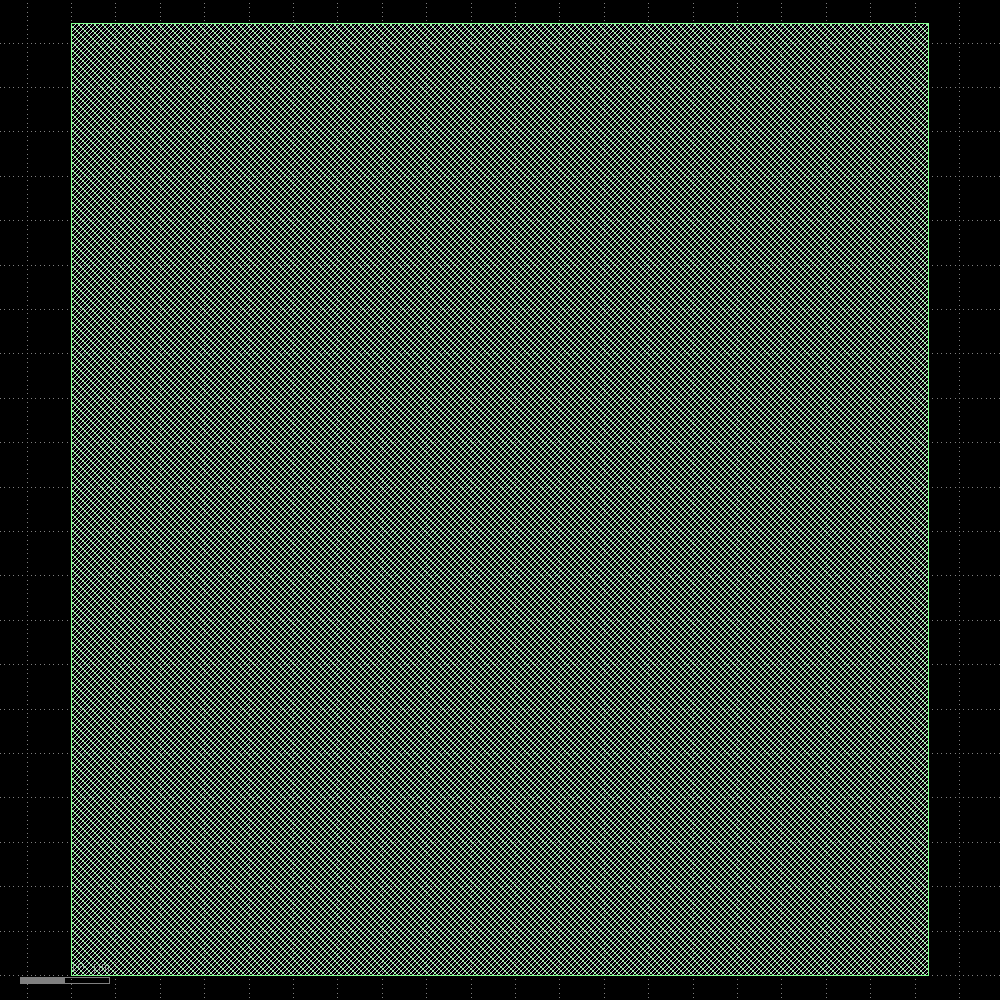

In [14]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [15]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[08:59:00] VERBOSE  Running 'OpenROAD.TapEndcapInsertion' at                                           ]8;id=899335;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=575204;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\
                    'librelane_run/3-openroad-tapendcapinsertion'…                                                 

[08:59:00] VERBOSE  Logging subprocess to                                                              ]8;id=640227;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=855419;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/3-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log'…                 

Reading OpenROAD database at '/content/librelane_run/2-openroad-floorplan/spm.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 62 endcaps.

[INFO TAP-0005] Inserted 99 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Inverter                                 64     240.23

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   447    4011.35

Writing OpenROAD database to '/content/librelane_run/3-openroad-tapendcapinsertion/spm.odb'…

Writing netlist to '/content/librelane_run/3-openroad-tapendcapinsertion/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/3-openroad-tapendcapinsertion/spm.pnl.v'…

Writing layout to '/content/librelane_run/3-openroad-tapendcapinsertion/spm.def'…

Writing timing constraints to '/content/librelane_run/3-openroad-tapendcapinsertion/spm.sdc'…

{'nl': Path('/content/librelane_run/3-openroad-tapendcapinsertion/spm.nl.v'), 'pnl': Path('/content/librelane_run/3-openroad-tapendcapinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/3-openroad-tapendcapinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/3-openroad-tapendcapinsertion/spm.odb'), 'sdc': Path('/content/librelane_run/3-openroad-tapendcapinsertion/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 36, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 62, 'design__instance__count__class:tap_cell': 99}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[08:59:07] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_1bkq1yqw'…               ]8;id=827385;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=384795;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:59:07] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_1bkq1yqw/klayout-render.log'…  ]8;id=665038;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=725699;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 1.23s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
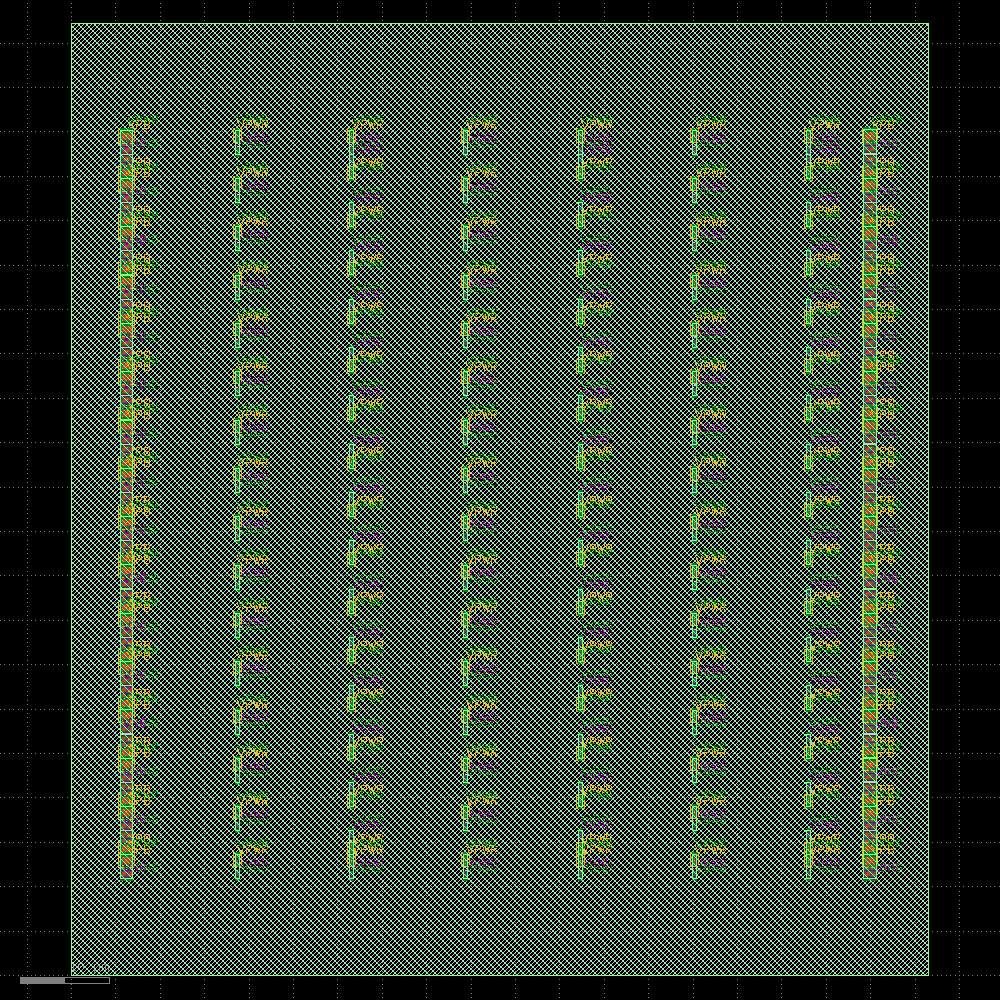

In [16]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [17]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[08:59:19] VERBOSE  Running 'OpenROAD.IOPlacement' at 'librelane_run/4-openroad-ioplacement'…          ]8;id=370305;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=2668;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:59:19] VERBOSE  Logging subprocess to                                                              ]8;id=101492;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=117770;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/4-openroad-ioplacement/openroad-ioplacement.log'…                               

Reading OpenROAD database at '/content/librelane_run/3-openroad-tapendcapinsertion/spm.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           124

[INFO PPL-0002] Number of I/O             36

[INFO PPL-0003] Number of I/O w/sink      36

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 2621.62 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Inverter                                 64     240.23

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   447    4011.35

Writing OpenROAD database to '/content/librelane_run/4-openroad-ioplacement/spm.odb'…

Writing netlist to '/content/librelane_run/4-openroad-ioplacement/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/4-openroad-ioplacement/spm.pnl.v'…

Writing layout to '/content/librelane_run/4-openroad-ioplacement/spm.def'…

Writing timing constraints to '/content/librelane_run/4-openroad-ioplacement/spm.sdc'…

{'nl': Path('/content/librelane_run/4-openroad-ioplacement/spm.nl.v'), 'pnl': Path('/content/librelane_run/4-openroad-ioplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/4-openroad-ioplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/4-openroad-ioplacement/spm.odb'), 'sdc': Path('/content/librelane_run/4-openroad-ioplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 36, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 62, 'design__instance__count__class:tap_cell': 99, 'floorplan__design__io': 36, 'design__io__hpwl': 2621616}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[08:59:34] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_d9000zvm'…               ]8;id=755585;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=528976;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:59:35] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_d9000zvm/klayout-render.log'…  ]8;id=284643;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=583106;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
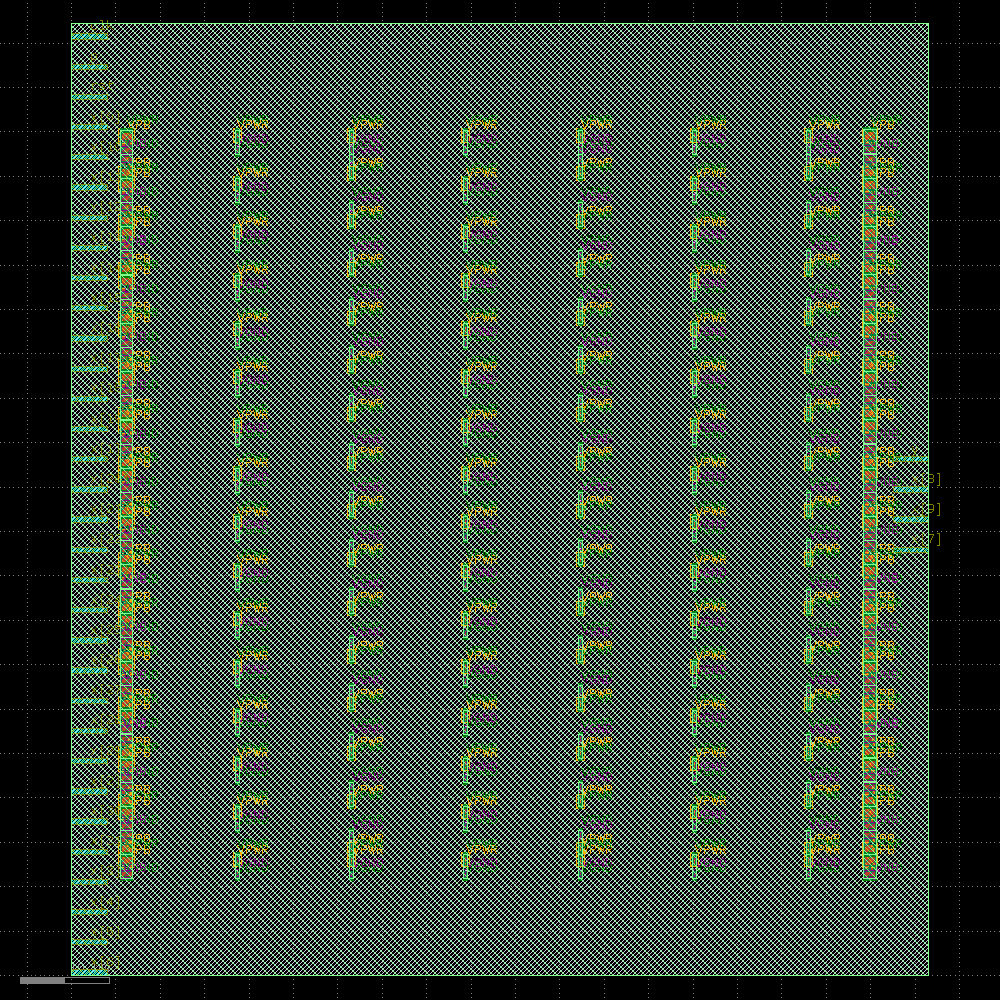

In [18]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://librelane.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [20]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[08:59:49] VERBOSE  Running 'OpenROAD.GeneratePDN' at 'librelane_run/6-openroad-generatepdn'…          ]8;id=330432;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=190285;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:59:49] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=887427;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=248279;file:///content/librelane_ipynb/librelane/steps/openroad.py#1184\1184]8;;\
                    /content/librelane_ipynb/librelane/scripts/openroad/common/pdn_cfg.tcl…                        

[08:59:49] VERBOSE  Logging subprocess to                                                              ]8;id=909509;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=692054;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/6-openroad-generatepdn/openroad-generatepdn.log'…                               

Reading OpenROAD database at '/content/librelane_run/4-openroad-ioplacement/spm.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Inverter                                 64     240.23

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   447    4011.35

Writing OpenROAD database to '/content/librelane_run/6-openroad-generatepdn/spm.odb'…

Writing netlist to '/content/librelane_run/6-openroad-generatepdn/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/6-openroad-generatepdn/spm.pnl.v'…

Writing layout to '/content/librelane_run/6-openroad-generatepdn/spm.def'…

Writing timing constraints to '/content/librelane_run/6-openroad-generatepdn/spm.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/librelane_run/6-openroad-generatepdn/spm.nl.v'), 'pnl': Path('/content/librelane_run/6-openroad-generatepdn/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/6-openroad-generatepdn/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/6-openroad-generatepdn/spm.odb'), 'sdc': Path('/content/librelane_run/6-openroad-generatepdn/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 62, 'design__instance__count__class:tap_cell': 99, 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[08:59:54] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_faikubdt'…               ]8;id=6285;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=869082;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[08:59:54] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_faikubdt/klayout-render.log'…  ]8;id=166617;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=113678;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
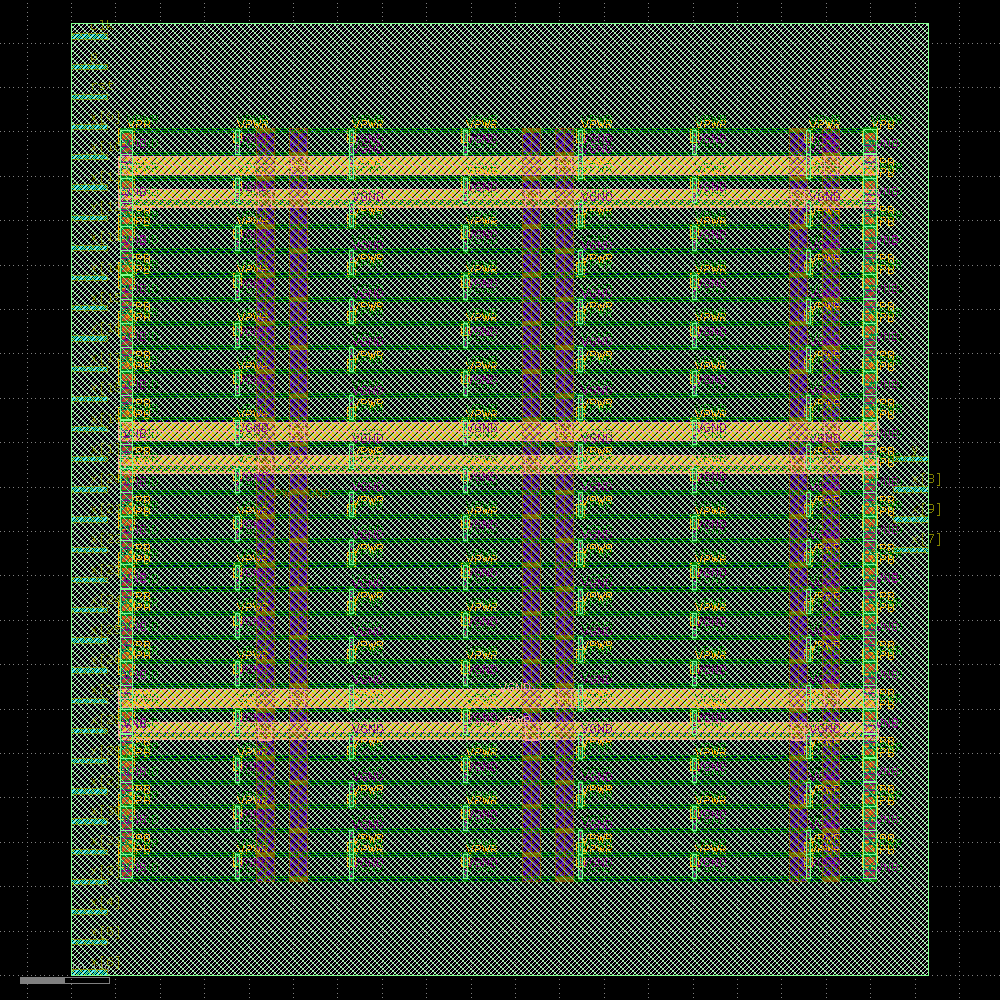

In [21]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [22]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[09:00:03] VERBOSE  Running 'OpenROAD.GlobalPlacement' at 'librelane_run/7-openroad-globalplacement'…  ]8;id=503859;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=300115;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[09:00:03] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=810267;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=563637;file:///content/librelane_ipynb/librelane/steps/openroad.py#1270\1270]8;;\
                    target density: 62.659100…                                                                     

[09:00:03] VERBOSE  Logging subprocess to                                                              ]8;id=332663;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=822292;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/7-openroad-globalplacement/openroad-globalplacement.log'…                       

Reading OpenROAD database at '/content/librelane_run/6-openroad-generatepdn/spm.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

+ global_placement -density 0.626591 -timing_driven -routability_driven -pad_right 0 -pad_left 0                   
-init_wirelength_coef 0.25

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 90.620 95.200 ) um

[INFO GPL-0006] NumInstances:               447

[INFO GPL-0007] NumPlaceInstances:          286

[INFO GPL-0008] NumFixedInstances:          161

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                    321

[INFO GPL-0011] NumPins:                    958

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 96.535 107.255 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 90.620 95.200 ) um

[INFO GPL-0016] CoreArea:              7175.632 um^2

[INFO GPL-0017] NonPlaceInstsArea:      356.592 um^2

[INFO GPL-0018] PlaceInstsArea:        3654.755 um^2

[INFO GPL-0019] Util:                    53.596 %

[INFO GPL-0020] StdInstsArea:          3654.755 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00000007 HPWL: 5542300

[InitialPlace]  Iter: 2 CG residual: 0.00000010 HPWL: 4828538

[InitialPlace]  Iter: 3 CG residual: 0.00000011 HPWL: 4596976

[InitialPlace]  Iter: 4 CG residual: 0.00000008 HPWL: 4534055

[InitialPlace]  Iter: 5 CG residual: 0.00000010 HPWL: 4512895

[INFO GPL-0031] FillerInit:NumGCells:       335

[INFO GPL-0032] FillerInit:NumGNets:        321

[INFO GPL-0033] FillerInit:NumGPins:        958

[INFO GPL-0023] TargetDensity:            0.627

[INFO GPL-0024] AvrgPlaceInstArea:       12.779 um^2

[INFO GPL-0025] IdealBinArea:            20.394 um^2

[INFO GPL-0026] IdealBinCnt:                351

[INFO GPL-0027] TotalBinArea:          7175.632 um^2

[INFO GPL-0028] BinCnt:        16     16

[INFO GPL-0029] BinSize: (  5.319  5.270 )

[INFO GPL-0030] NumBins: 256

[NesterovSolve] Iter:    1 overflow: 0.823 HPWL: 2073380

[NesterovSolve] Iter:   10 overflow: 0.788 HPWL: 2147962

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 6.66e-09

[INFO GPL-0103] Timing-driven: weighted 31 nets.

[NesterovSolve] Iter:   20 overflow: 0.765 HPWL: 2190447

[NesterovSolve] Iter:   30 overflow: 0.766 HPWL: 2187327

[NesterovSolve] Iter:   40 overflow: 0.772 HPWL: 2175197

[NesterovSolve] Iter:   50 overflow: 0.769 HPWL: 2179122

[NesterovSolve] Iter:   60 overflow: 0.768 HPWL: 2182546

[NesterovSolve] Iter:   70 overflow: 0.769 HPWL: 2179384

[NesterovSolve] Iter:   80 overflow: 0.769 HPWL: 2178387

[NesterovSolve] Iter:   90 overflow: 0.767 HPWL: 2178819

[NesterovSolve] Iter:  100 overflow: 0.767 HPWL: 2176974

[NesterovSolve] Iter:  110 overflow: 0.765 HPWL: 2174361

[NesterovSolve] Iter:  120 overflow: 0.762 HPWL: 2172850

[NesterovSolve] Iter:  130 overflow: 0.757 HPWL: 2170730

[NesterovSolve] Iter:  140 overflow: 0.751 HPWL: 2169763

[NesterovSolve] Iter:  150 overflow: 0.741 HPWL: 2163928

[NesterovSolve] Iter:  160 overflow: 0.723 HPWL: 2155844

[NesterovSolve] Iter:  170 overflow: 0.712 HPWL: 2182158

[NesterovSolve] Iter:  180 overflow: 0.698 HPWL: 2219238

[NesterovSolve] Iter:  190 overflow: 0.659 HPWL: 2291781

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 6.63e-09

[INFO GPL-0103] Timing-driven: weighted 31 nets.

[NesterovSolve] Iter:  200 overflow: 0.624 HPWL: 2375650

[NesterovSolve] Snapshot saved at iter = 203

[NesterovSolve] Iter:  210 overflow: 0.575 HPWL: 2438989

[NesterovSolve] Iter:  220 overflow: 0.527 HPWL: 2506346

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 6.61e-09

[INFO GPL-0103] Timing-driven: weighted 31 nets.

[NesterovSolve] Iter:  230 overflow: 0.455 HPWL: 2585676

[NesterovSolve] Iter:  240 overflow: 0.400 HPWL: 2628342

[NesterovSolve] Iter:  250 overflow: 0.356 HPWL: 2693655

[NesterovSolve] Iter:  260 overflow: 0.339 HPWL: 2709366

[NesterovSolve] Iter:  270 overflow: 0.317 HPWL: 2716785

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      13   15

[INFO GPL-0040] NumTiles: 195

[INFO GPL-0081] TotalRouteOverflow: 0

[INFO GPL-0082] OverflowTileCnt: 0

[INFO GPL-0083] 0.5%RC: 0.7695683836936951

[INFO GPL-0084] 1.0%RC: 0.7347541451454163

[INFO GPL-0085] 2.0%RC: 0.7092161774635315

[INFO GPL-0086] 5.0%RC: 0.6819598972797394

[INFO GPL-0087] FinalRC: 0.75216126

[INFO GPL-0077] FinalRC lower than targetRC(1.01), routability not needed.

[NesterovSolve] Iter:  280 overflow: 0.294 HPWL: 2753339

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 6.57e-09

[INFO GPL-0103] Timing-driven: weighted 31 nets.

[NesterovSolve] Iter:  290 overflow: 0.280 HPWL: 2771995

[NesterovSolve] Iter:  300 overflow: 0.266 HPWL: 2786319

[NesterovSolve] Iter:  310 overflow: 0.251 HPWL: 2806170

[NesterovSolve] Iter:  320 overflow: 0.234 HPWL: 2830183

[NesterovSolve] Iter:  330 overflow: 0.214 HPWL: 2877693

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 6.55e-09

[INFO GPL-0103] Timing-driven: weighted 30 nets.

[NesterovSolve] Iter:  340 overflow: 0.189 HPWL: 2913512

[NesterovSolve] Iter:  350 overflow: 0.155 HPWL: 2928423

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 6.54e-09

[INFO GPL-0103] Timing-driven: weighted 31 nets.

[NesterovSolve] Iter:  360 overflow: 0.132 HPWL: 2950113

[NesterovSolve] Iter:  370 overflow: 0.116 HPWL: 2981089

[NesterovSolve] Finished with Overflow: 0.098540

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Inverter                                 64     240.23

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   447    4011.35

Writing OpenROAD database to '/content/librelane_run/7-openroad-globalplacement/spm.odb'…

Writing netlist to '/content/librelane_run/7-openroad-globalplacement/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/7-openroad-globalplacement/spm.pnl.v'…

Writing layout to '/content/librelane_run/7-openroad-globalplacement/spm.def'…

Writing timing constraints to '/content/librelane_run/7-openroad-globalplacement/spm.sdc'…

{'nl': Path('/content/librelane_run/7-openroad-globalplacement/spm.nl.v'), 'pnl': Path('/content/librelane_run/7-openroad-globalplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/7-openroad-globalplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/7-openroad-globalplacement/spm.odb'), 'sdc': Path('/content/librelane_run/7-openroad-globalplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 62, 'design__instance__count__class:tap_cell': 99, 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[09:00:16] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_go312o65'…               ]8;id=962019;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=180248;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[09:00:16] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_go312o65/klayout-render.log'…  ]8;id=942317;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=50597;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 3.46s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
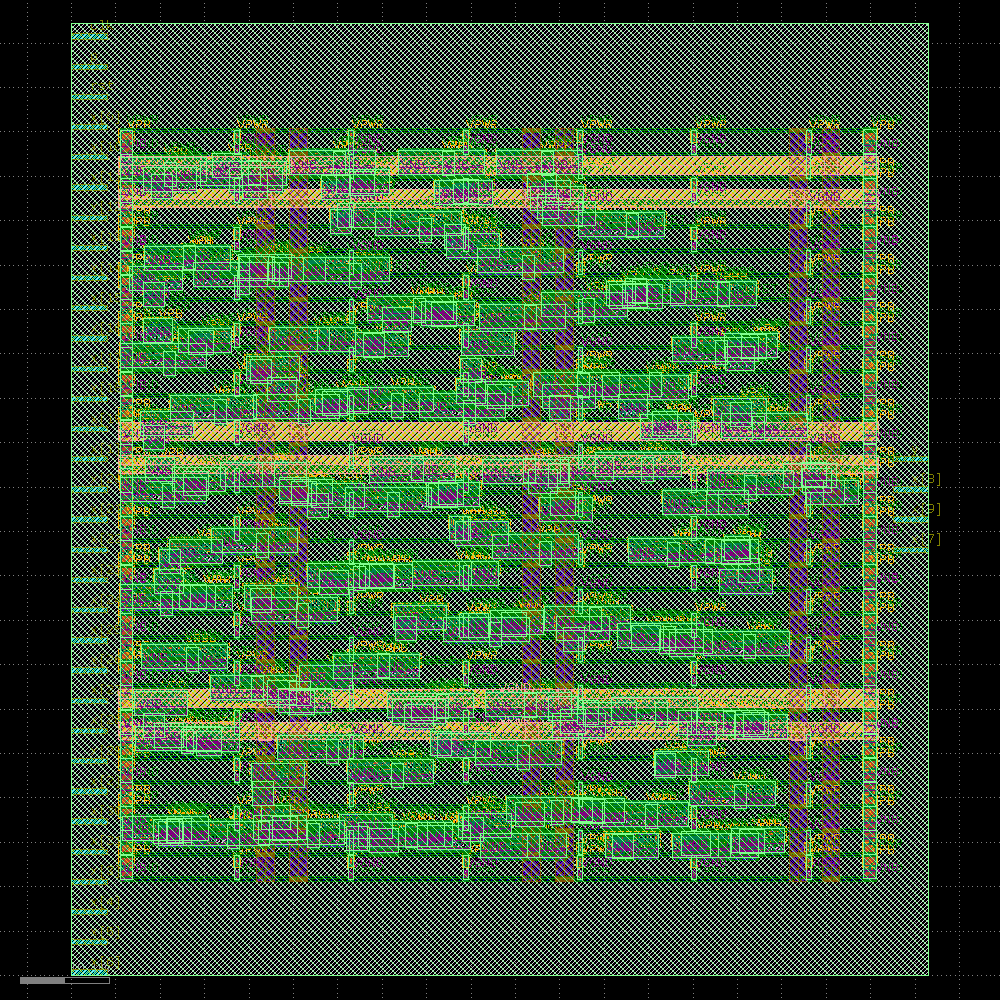

In [23]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [24]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[09:00:21] VERBOSE  Running 'OpenROAD.DetailedPlacement' at                                            ]8;id=69863;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=602348;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\
                    'librelane_run/8-openroad-detailedplacement'…                                                  

[09:00:21] VERBOSE  Logging subprocess to                                                              ]8;id=632920;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=568389;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/8-openroad-detailedplacement/openroad-detailedplacement.log'…                   

Reading OpenROAD database at '/content/librelane_run/7-openroad-globalplacement/spm.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Placement Analysis

---------------------------------

total displacement        762.3 u

average displacement        1.7 u

max displacement            9.9 u

original HPWL            3045.4 u

legalized HPWL           4014.9 u

delta HPWL                   32 %

[INFO DPL-0020] Mirrored 99 instances

[INFO DPL-0021] HPWL before            4014.9 u

[INFO DPL-0022] HPWL after             3798.2 u

[INFO DPL-0023] HPWL delta               -5.4 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Inverter                                 64     240.23

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   447    4011.35

Writing OpenROAD database to '/content/librelane_run/8-openroad-detailedplacement/spm.odb'…

Writing netlist to '/content/librelane_run/8-openroad-detailedplacement/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/8-openroad-detailedplacement/spm.pnl.v'…

Writing layout to '/content/librelane_run/8-openroad-detailedplacement/spm.def'…

Writing timing constraints to '/content/librelane_run/8-openroad-detailedplacement/spm.sdc'…

{'nl': Path('/content/librelane_run/8-openroad-detailedplacement/spm.nl.v'), 'pnl': Path('/content/librelane_run/8-openroad-detailedplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/8-openroad-detailedplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/8-openroad-detailedplacement/spm.odb'), 'sdc': Path('/content/librelane_run/8-openroad-detailedplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 62, 'design__instance__count__class:tap_cell': 99, 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('762.271'), 'design__instance__displacement__mean': Decimal('1.705'), 'design__instance__displacement__max': Decimal('9.919'), 'route__wirelength__estimated': Decimal('4014.91'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[09:00:24] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_pjwlse_q'…               ]8;id=200254;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=362266;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[09:00:24] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_pjwlse_q/klayout-render.log'…  ]8;id=856294;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=983682;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
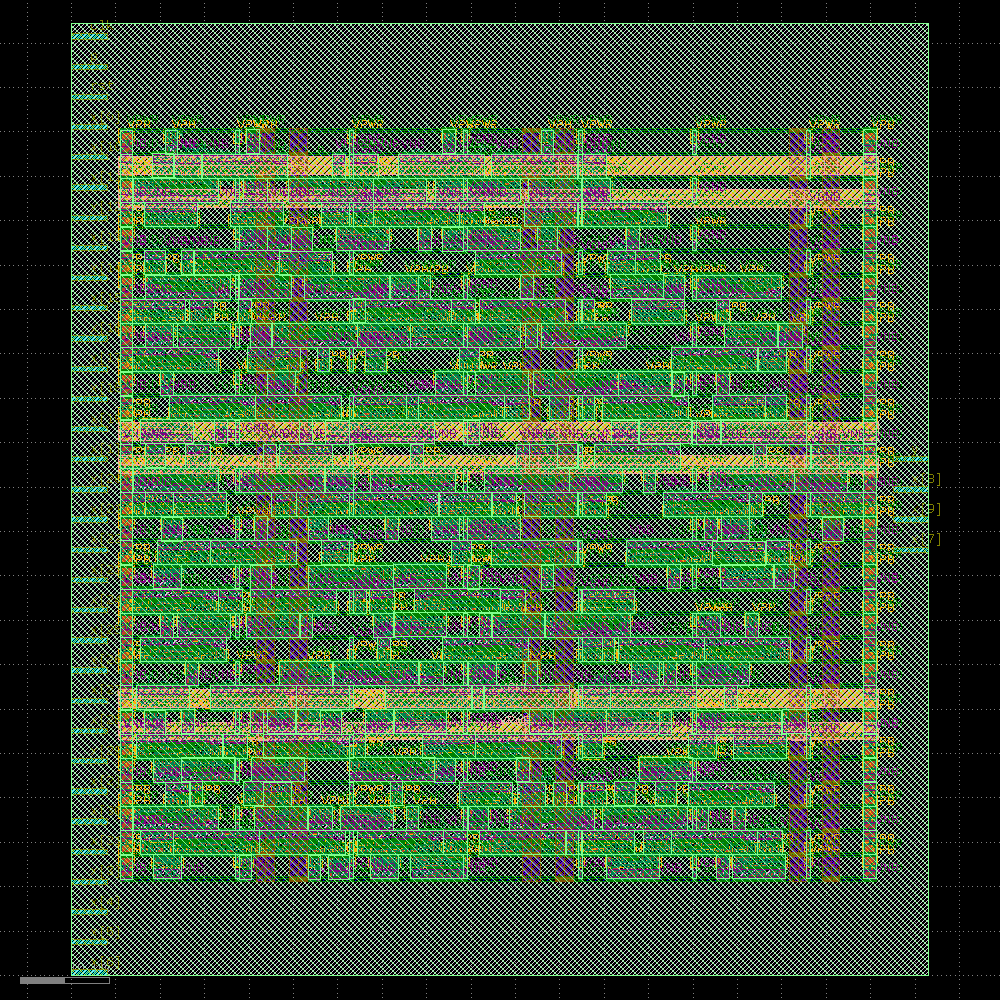

In [25]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [26]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[09:00:30] VERBOSE  Running 'OpenROAD.CTS' at 'librelane_run/9-openroad-cts'…                          ]8;id=857800;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=359019;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[09:00:30] VERBOSE  Logging subprocess to 'librelane_run/9-openroad-cts/openroad-cts.log'…             ]8;id=724854;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=781464;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/librelane_run/8-openroad-detailedplacement/spm.odb'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 64 sinks.

[INFO CTS-0008] TritonCTS found 1 clock nets.

[INFO CTS-0097] Characterization used 3 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 64.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(7165, 15020), (73405, 91180)].

[INFO CTS-0024]  Normalized sink region: [(0.526838, 1.10441), (5.39743, 6.70441)].

[INFO CTS-0025]     Width:  4.8706.

[INFO CTS-0026]     Height: 5.6000.

Level 1

Direction: Vertical

Sinks per sub-region: 32

Sub-region size: 4.8706 X 2.8000

[INFO CTS-0034]     Segment length (rounded): 1.

Level 2

Direction: Horizontal

Sinks per sub-region: 16

Sub-region size: 2.4353 X 2.8000

[INFO CTS-0034]     Segment length (rounded): 1.

Level 3

Direction: Vertical

Sinks per sub-region: 8

Sub-region size: 2.4353 X 1.4000

[INFO CTS-0034]     Segment length (rounded): 1.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 64.

[INFO CTS-0018]     Created 9 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 9 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 6:1, 7:3, 8:1, 9:1, 10:2..

[INFO CTS-0017]     Max level of the clock tree: 3.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 70

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 140.82 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 6

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Clock buffer                             11     246.49

Inverter                                 64     240.23

Clock inverter                            4      45.04

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   462    4302.88

Writing OpenROAD database to '/content/librelane_run/9-openroad-cts/spm.odb'…

Writing netlist to '/content/librelane_run/9-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/9-openroad-cts/spm.pnl.v'…

Writing layout to '/content/librelane_run/9-openroad-cts/spm.def'…

Writing timing constraints to '/content/librelane_run/9-openroad-cts/spm.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement        146.9 u

average displacement        0.3 u

max displacement            8.3 u

original HPWL            4167.7 u

legalized HPWL           4563.8 u

delta HPWL                   10 %

[INFO DPL-0020] Mirrored 102 instances

[INFO DPL-0021] HPWL before            4563.8 u

[INFO DPL-0022] HPWL after             4320.2 u

[INFO DPL-0023] HPWL delta               -5.3 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Clock buffer                             11     246.49

Inverter                                 64     240.23

Clock inverter                            4      45.04

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   462    4302.88

Writing OpenROAD database to '/content/librelane_run/9-openroad-cts/spm.odb'…

Writing netlist to '/content/librelane_run/9-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/librelane_run/9-openroad-cts/spm.pnl.v'…

Writing layout to '/content/librelane_run/9-openroad-cts/spm.def'…

Writing timing constraints to '/content/librelane_run/9-openroad-cts/spm.sdc'…

{'nl': Path('/content/librelane_run/9-openroad-cts/spm.nl.v'), 'pnl': Path('/content/librelane_run/9-openroad-cts/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/9-openroad-cts/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/9-openroad-cts/spm.odb'), 'sdc': Path('/content/librelane_run/9-openroad-cts/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4070.15'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4070.15'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.567219'), 'design__instance__utilization__stdcell': Decimal('0.567219'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 62, 'design__instance__count__class:tap_cell': 99, 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('146.884'), 'design__instance__displacement__mean': Decimal('0.317'), 'design__instance__displacement__max': Decimal('8.28'), 'route__wirelength__estimated': Decimal('4563.83'), 'design__violations': 0, 'design__instance__count__class:clock_buffer': 11, 'design__instance__count__class:clock_inverter': 4}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[09:00:44] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_fgyrn747'…               ]8;id=373066;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=892065;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[09:00:44] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_fgyrn747/klayout-render.log'…  ]8;id=723354;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=944313;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 13.84s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
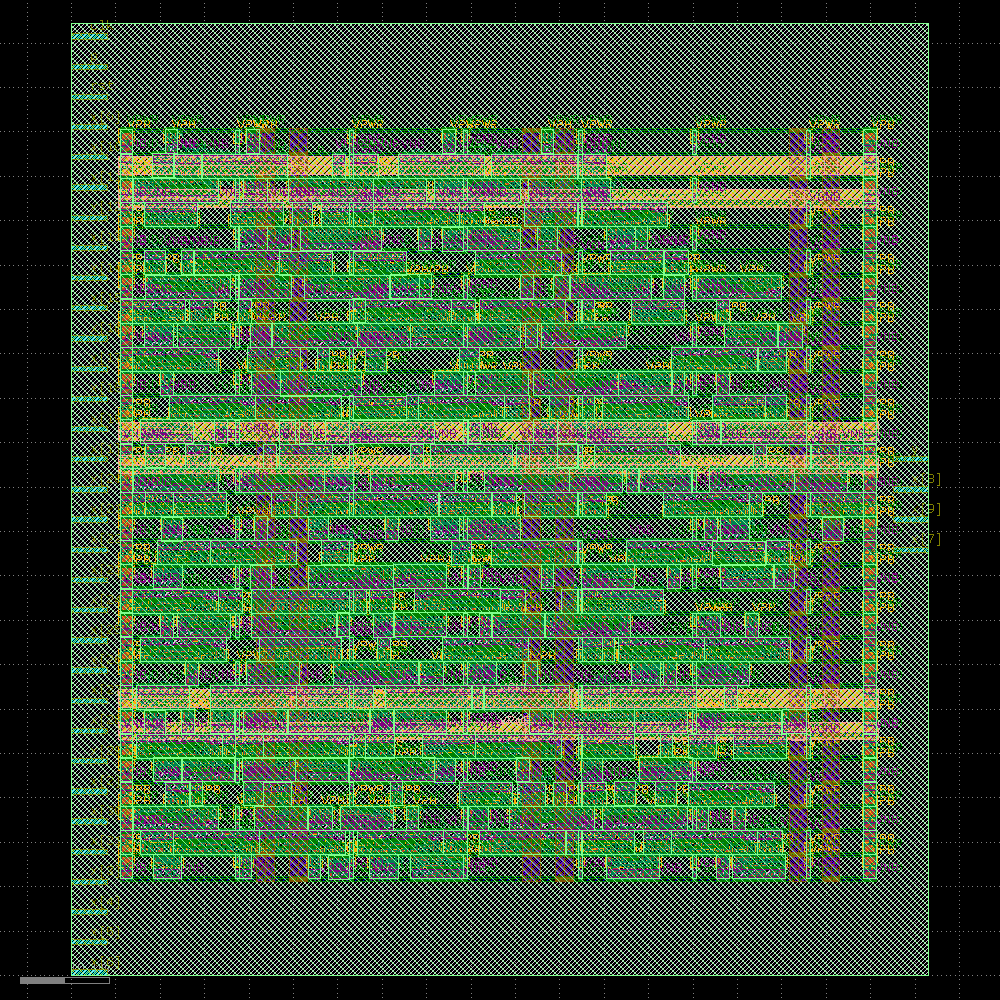

In [27]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [28]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[09:00:49] VERBOSE  Running 'OpenROAD.GlobalRouting' at 'librelane_run/10-openroad-globalrouting'…     ]8;id=614531;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=573322;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[09:00:49] VERBOSE  Logging subprocess to                                                              ]8;id=800596;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=569412;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/10-openroad-globalrouting/openroad-globalrouting.log'…                          

Reading OpenROAD database at '/content/librelane_run/9-openroad-cts/spm.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 10 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 65

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 1206

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal       4003          1889          52.81%

met2       Vertical         3165          1951          38.36%

met3       Horizontal       1995          1263          36.69%

met4       Vertical         1302           642          50.69%

met5       Horizontal        399           168          57.89%

---------------------------------------------------------------

[INFO GRT-0197] Via related to pin nodes: 1518

[INFO GRT-0198] Via related Steiner nodes: 10

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 1860

[INFO GRT-0112] Final usage 3D: 6344

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1              1889           298           15.78%             0 /  0 /  0

met2              1951           331           16.97%             0 /  0 /  0

met3              1263           135           10.69%             0 /  0 /  0

met4               642             0            0.00%             0 /  0 /  0

met5               168             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total             5913           764           12.92%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 9280 um

[INFO GRT-0014] Routed nets: 330

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                62     232.72

Tap cell                                 99     123.87

Clock buffer                             11     246.49

Inverter                                 64     240.23

Clock inverter                            4      45.04

Sequential cell                          64    1681.61

Multi-Input combinational cell          158    1732.91

Total                                   462    4302.88

Writing OpenROAD database to '/content/librelane_run/10-openroad-globalrouting/spm.odb'…

Writing layout to '/content/librelane_run/10-openroad-globalrouting/spm.def'…

{'nl': Path('/content/librelane_run/9-openroad-cts/spm.nl.v'), 'pnl': Path('/content/librelane_run/9-openroad-cts/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/10-openroad-globalrouting/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/10-openroad-globalrouting/spm.odb'), 'sdc': Path('/content/librelane_run/9-openroad-cts/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4070.15'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4070.15'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.567219'), 'design__instance__utilization__stdcell': Decimal('0.567219'), 'design__instance__count__class:inverter': 64, 'design__instance__count__class:sequential_cell': 64, 'design__instance__count__class:multi_input_combinational_cell': 158, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 62, 'design__instance__count__class:tap_cell': 99, 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('146.884'), 'design__instance__displacement__mean': Decimal('0.317'), 'design__instance__displacement__max': Decimal('8.28'), 'route__wirelength__estimated': Decimal('4563.83'), 'design__violations': 0, 'design__instance__count__class:clock_buffer': 11, 'design__instance__count__class:clock_inverter': 4, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [ ]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[09:00:53] VERBOSE  Running 'OpenROAD.DetailedRouting' at 'librelane_run/11-openroad-detailedrouting'… ]8;id=331142;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=379295;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[09:00:53] INFO     Running TritonRoute with 2 threads…                                            ]8;id=928974;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=348143;file:///content/librelane_ipynb/librelane/steps/openroad.py#1634\1634]8;;\

[09:00:53] VERBOSE  Logging subprocess to                                                              ]8;id=318575;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=327048;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/11-openroad-detailedrouting/openroad-detailedrouting.log'…                      

Reading OpenROAD database at '/content/librelane_run/10-openroad-globalrouting/spm.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=962862;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=748964;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer mcon                                                                                     

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=520576;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=851804;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer mcon                                                                                     

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=891245;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=780275;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via                                                                                      

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=776892;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=903723;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via                                                                                      

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=488027;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=262595;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via2                                                                                     

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=480218;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=350026;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via2                                                                                     

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=633402;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=409131;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via3                                                                                     

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=657028;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=571226;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via3                                                                                     

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=761004;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=230372;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via4                                                                                     

[09:00:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=819750;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=269644;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   spm

Die area:                 ( 0 0 ) ( 96535 107255 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     462

Number of terminals:      38

Number of snets:          2

Number of nets:           330

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 45.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete licon.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] licon shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 12469.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 2289.

[INFO DRT-0033] via shape region query size = 576.

[INFO DRT-0033] met2 shape region query size = 192.

[INFO DRT-0033] via2 shape region query size = 480.

[INFO DRT-0033] met3 shape region query size = 324.

[INFO DRT-0033] via3 shape region query size = 480.

[INFO DRT-0033] met4 shape region query size = 126.

[INFO DRT-0033] via4 shape region query size = 18.

[INFO DRT-0033] met5 shape region query size = 30.

[INFO DRT-0165] Start pin access.

[INFO DRT-0078]   Complete 113 pins.

[INFO DRT-0081]   Complete 39 unique inst patterns.

[INFO DRT-0084]   Complete 213 groups.

In [ ]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [ ]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

In [ ]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://librelane.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [ ]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://librelane.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of LibreLane right now are not super
reliable for timing purposes and are only provided for completeness.

When using LibreLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [ ]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [ ]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

In [ ]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [ ]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [ ]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [1]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

NameError: name 'Step' is not defined